In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duchu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
dataset_path = 'Twitter_Data.csv'
df =pd.read_csv(dataset_path)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [21]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [22]:
df[df.isna().any(axis=1)]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [24]:
df = df.dropna()

In [25]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlink removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctrutation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text


In [29]:
vecterizer = TfidfVectorizer(max_features=2000)
X = vecterizer.fit_transform(df['clean_text'].apply(text_normalize)).toarray()

In [28]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [34]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)

y_encoded = np.array([np.zeros(n_classes) for i in range(n_samples)])

y_encoded[np.arange(n_samples), y] = 1

In [35]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded, 
    test_size=val_size, 
    random_state=random_state, 
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, 
    test_size=test_size, 
    random_state=random_state, 
    shuffle=is_shuffle
)

In [37]:
def soft_max(z):
    exp_z = np.exp(z)

    return exp_z / exp_z.sum(axis=1)[:, None]

def predict(X, theta):
    z = np.dot(X, theta)
    return soft_max(z)

def compute_gradient(X, y, y_pred):
    n = y.size

    return np.dot(X.T, (y_pred - y)) / n

def update_theta(theta, grad, lr):
    return theta - lr * grad

def compute_loss(y_hat , y):
    n = y.shape[0]
    return (-1 / n) * np.sum(y * np.log(y_hat + 1e-9))

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

    return acc

In [36]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size=(n_features, n_classes)
)

In [38]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs =  []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)                     

        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss :.3f}\ tValidation loss: {val_batch_loss :.3f}')

<>:44: SyntaxWarning: invalid escape sequence '\ '
<>:44: SyntaxWarning: invalid escape sequence '\ '
C:\Users\duchu\AppData\Local\Temp\ipykernel_21444\705764239.py:44: SyntaxWarning: invalid escape sequence '\ '
  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss :.3f}\ tValidation loss: {val_batch_loss :.3f}')



EPOCH 1:	Training loss: 1.138\ tValidation loss: 1.136

EPOCH 2:	Training loss: 1.136\ tValidation loss: 1.135

EPOCH 3:	Training loss: 1.135\ tValidation loss: 1.134

EPOCH 4:	Training loss: 1.134\ tValidation loss: 1.133

EPOCH 5:	Training loss: 1.133\ tValidation loss: 1.132

EPOCH 6:	Training loss: 1.132\ tValidation loss: 1.131

EPOCH 7:	Training loss: 1.131\ tValidation loss: 1.130

EPOCH 8:	Training loss: 1.130\ tValidation loss: 1.129

EPOCH 9:	Training loss: 1.129\ tValidation loss: 1.128

EPOCH 10:	Training loss: 1.129\ tValidation loss: 1.127

EPOCH 11:	Training loss: 1.128\ tValidation loss: 1.126

EPOCH 12:	Training loss: 1.127\ tValidation loss: 1.125

EPOCH 13:	Training loss: 1.126\ tValidation loss: 1.125

EPOCH 14:	Training loss: 1.125\ tValidation loss: 1.124

EPOCH 15:	Training loss: 1.124\ tValidation loss: 1.123

EPOCH 16:	Training loss: 1.123\ tValidation loss: 1.122

EPOCH 17:	Training loss: 1.123\ tValidation loss: 1.121

EPOCH 18:	Training loss: 1.122\ tValida

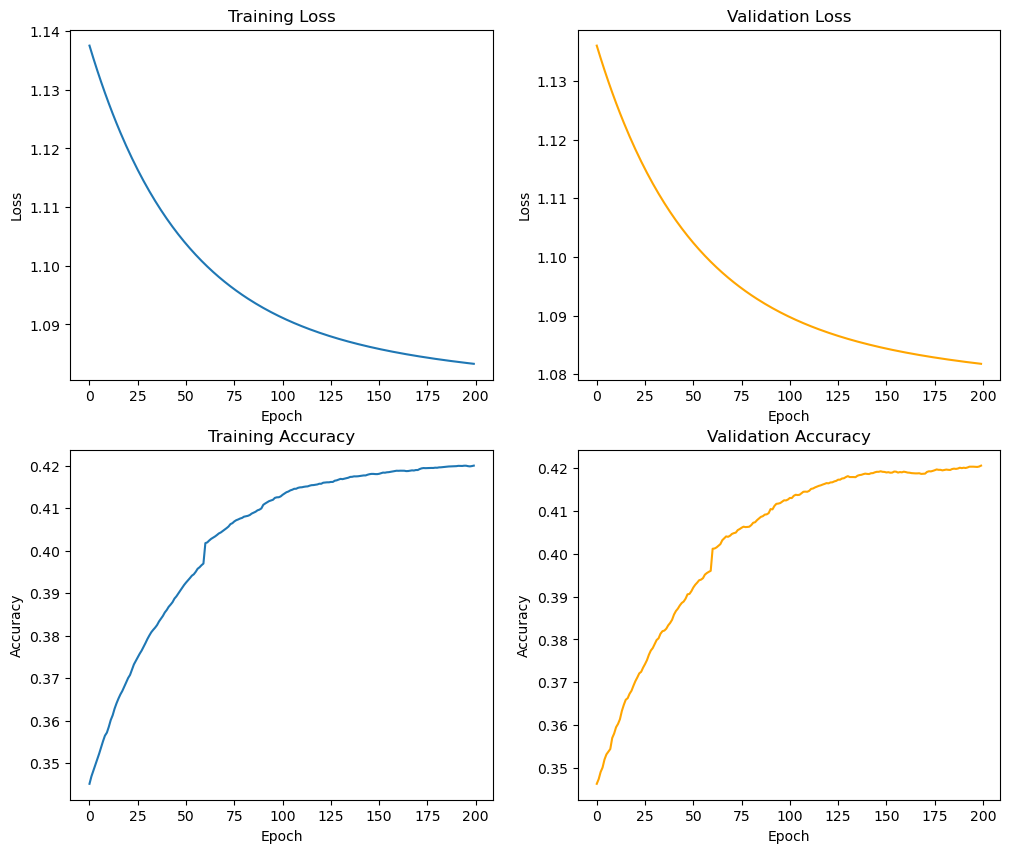

In [39]:
fig , ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses , 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs , 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
val_set_acc = compute_accuracy(X_val , y_val , theta)
test_set_acc = compute_accuracy(X_test , y_test , theta)
print('Evaluation on validation and test set:')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Accuracy: 0.42059888323004235
Accuracy: 0.4190341780695834
